# Module 2: Medical Data Fundamentals
## Garbage In, Harm Out

**Goal:** Learn how data quality, units, leakage, bias, and privacy decisions shape clinical AI safety.

### How to use this notebook
- Run cells from top to bottom.
- Change widget settings to see how results shift.
- This module is still conceptual and lightweight: no `model.fit()` yet.

### Learning objectives
1. Recognize common medical data pitfalls before model training.
2. Handle missing data and unit mismatches in a reproducible way.
3. Detect label leakage that creates fake performance.
4. Inspect subgroup imbalance and privacy risk in tabular clinical data.
5. Export a cleaned table ready for Module 3.

## Section 0: Clinical Vignette
A hospital team built a 30-day readmission risk model that looked strong in development,
but failed after deployment. Root causes were data quality and framing mistakes, not model architecture.

We will audit a synthetic EHR extract and prepare a safe handoff dataset.

## Helper Functions
Run this cell once at the start. It auto-configures paths in Google Colab and does nothing harmful on local Jupyter.

In [ ]:
import os
import sys
import subprocess
from pathlib import Path

def setup_repo_for_colab(
    repo_url='https://github.com/aaekay/Medical-AI-101.git',
    repo_dir='/content/Medical-AI-101',
    notebook_dir='chapters',
):
    if 'google.colab' not in sys.modules:
        print(f'Local runtime detected. Working directory: {Path.cwd()}')
        return

    repo_path = Path(repo_dir)
    if not repo_path.exists():
        print('Cloning Medical-AI-101 into /content ...')
        subprocess.check_call(['git', 'clone', repo_url, str(repo_path)])

    target = repo_path / notebook_dir
    os.chdir(target)
    print(f'Colab ready. Working directory: {Path.cwd()}')

setup_repo_for_colab()


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import ipywidgets as widgets
    from IPython.display import display
except ImportError as exc:
    raise ImportError('ipywidgets is required for interactive demos.') from exc

def resolve_data_path(filename):
    candidates = [Path('../data') / filename, Path('data') / filename]
    for cand in candidates:
        if cand.exists():
            return cand
    raise FileNotFoundError(f'Could not locate {filename} in ../data or data/')

DATA_PATH = resolve_data_path('module_02_readmission_dirty.csv')
df_raw = pd.read_csv(DATA_PATH)
print(f'Loaded {len(df_raw)} rows and {df_raw.shape[1]} columns from {DATA_PATH}.')

Loaded 128 rows and 18 columns from ../data/module_02_readmission_dirty.csv.


In [2]:
quality_snapshot = pd.DataFrame({
    'rows': [len(df_raw)],
    'columns': [df_raw.shape[1]],
    'duplicate_encounter_ids': [df_raw.duplicated(subset=['encounter_id']).sum()],
    'missing_cells': [int(df_raw.isna().sum().sum())],
})

display(df_raw.head(8))
display(quality_snapshot)

,encounter_id,patient_id,patient_name,date_of_birth,zip_code,age,sex,race_group,insurance_type,smoke,sbp,ldl_value,ldl_unit,comorbidity_count,prior_admissions_12m,followup_scheduled_7d,future_ed_visit_30d,readmit_30d
0,10001,5007,Drew Lee,1961-02-11,NaN,64.0,Female,Hispanic,Commercial,0.0,130.0,141.30,mg/dL,0.0,1.0,1.0,0.0,0
1,10002,5065,Quinn Moore,1964-08-27,48201.0,60.0,Female,Asian,Commercial,1.0,138.3,140.50,mg/dL,0.0,0.0,0.0,0.0,0
2,10003,5055,Quinn Johnson,1958-04-08,60612.0,66.0,Female,Black,Commercial,1.0,145.8,174.30,mg/dL,1.0,3.0,0.0,1.0,1
3,10004,5037,Jamie Martin,1945-03-05,10027.0,80.0,Female,Black,Commercial,1.0,134.2,126.40,mg/dL,3.0,2.0,0.0,1.0,1
4,10005,5036,Kendall Martin,1960-07-20,2139.0,65.0,Female,Hispanic,Medicaid,1.0,134.4,149.30,mg/dL,1.0,1.0,1.0,1.0,0
5,10006,5072,Skyler Johnson,1969-05-06,60612.0,56.0,Female,White,Commercial,1.0,146.8,106.40,mg/dL,2.0,1.0,1.0,0.0,0
6,10007,5007,Sam Harris,1947-08-26,10027.0,77.0,Female,White,Commercial,1.0,130.9,3.94,mmol/L,2.0,0.0,0.0,0.0,0
7,10008,5059,Rowan Anderson,1957-04-25,85013.0,68.0,Female,White,Commercial,0.0,118.9,138.10,mg/dL,6.0,1.0,1.0,0.0,0


,rows,columns,duplicate_encounter_ids,missing_cells
0,128,18,8,43


## Section 1: Data Map and Missingness
Before modeling, we need to understand what each column means and where breakpoints exist.

,column,type,clinical meaning,common issue
0,age,Structured numeric,Age at discharge,Missing or impossible values
1,sbp,Structured numeric,Systolic blood pressure,Outliers from charting error
2,ldl_value + ldl_unit,Structured numeric + unit,LDL lab result,Unit mismatch (mg/dL vs mmol/L)
3,future_ed_visit_30d,Post-outcome flag,ED use after discharge,Label leakage if used as feature
4,patient_name/date_of_birth/zip_code,Identifiers,Patient identity,Privacy and re-identification risk


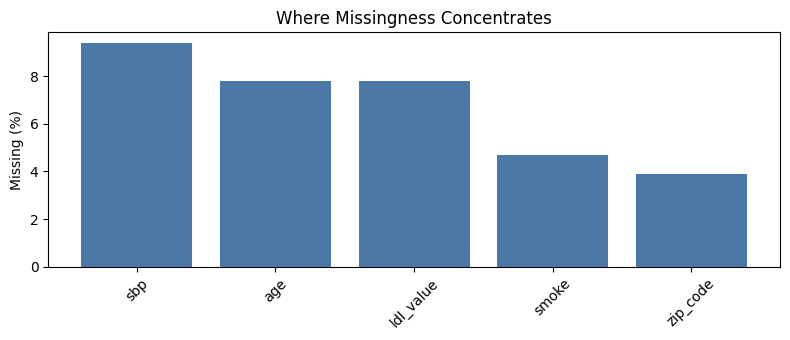

In [3]:
data_map = pd.DataFrame([
    {'column': 'age', 'type': 'Structured numeric', 'clinical meaning': 'Age at discharge', 'common issue': 'Missing or impossible values'},
    {'column': 'sbp', 'type': 'Structured numeric', 'clinical meaning': 'Systolic blood pressure', 'common issue': 'Outliers from charting error'},
    {'column': 'ldl_value + ldl_unit', 'type': 'Structured numeric + unit', 'clinical meaning': 'LDL lab result', 'common issue': 'Unit mismatch (mg/dL vs mmol/L)'},
    {'column': 'future_ed_visit_30d', 'type': 'Post-outcome flag', 'clinical meaning': 'ED use after discharge', 'common issue': 'Label leakage if used as feature'},
    {'column': 'patient_name/date_of_birth/zip_code', 'type': 'Identifiers', 'clinical meaning': 'Patient identity', 'common issue': 'Privacy and re-identification risk'},
])
display(data_map)

missing_pct = (df_raw.isna().mean() * 100).sort_values(ascending=False)
missing_pct = missing_pct[missing_pct > 0]

if not missing_pct.empty:
    fig, ax = plt.subplots(figsize=(8, 3.5))
    ax.bar(missing_pct.index, missing_pct.values, color='#4c78a8')
    ax.set_ylabel('Missing (%)')
    ax.set_title('Where Missingness Concentrates')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

## Section 2: Interactive Demo - Missing Data Choices
Different handling strategies change both coverage and apparent performance.

In [ ]:
def to_mg_dl(ldl_value, ldl_unit):
    factor = np.where(ldl_unit == 'mmol/L', 38.67, 1.0)
    return ldl_value * factor

base = df_raw.copy()
base['ldl_mg_dl'] = to_mg_dl(base['ldl_value'], base['ldl_unit'])
base.loc[(base['sbp'] < 70) | (base['sbp'] > 260), 'sbp'] = np.nan
base.loc[(base['age'] < 18) | (base['age'] > 100), 'age'] = np.nan

num_cols = ['age', 'sbp', 'ldl_mg_dl', 'smoke', 'comorbidity_count', 'prior_admissions_12m']

def score_rule(frame):
    z = (frame[num_cols] - frame[num_cols].mean()) / frame[num_cols].std(ddof=0)
    score = (
        0.60 * z['age']
        + 0.80 * z['sbp']
        + 0.75 * z['ldl_mg_dl']
        + 0.55 * z['smoke']
        + 0.70 * z['comorbidity_count']
        + 0.85 * z['prior_admissions_12m']
    )
    return (score > 0.25).astype(int)

def run_missing_demo(strategy='Drop rows'):
    temp = base.copy()

    if strategy == 'Drop rows':
        temp = temp.dropna(subset=num_cols + ['readmit_30d'])
    elif strategy == 'Mean imputation':
        temp[num_cols] = temp[num_cols].fillna(temp[num_cols].mean())
        temp = temp.dropna(subset=['readmit_30d'])
    elif strategy == 'Median imputation':
        temp[num_cols] = temp[num_cols].fillna(temp[num_cols].median())
        temp = temp.dropna(subset=['readmit_30d'])
    else:
        defaults = {
            'age': temp['age'].median(),
            'sbp': temp['sbp'].median(),
            'ldl_mg_dl': 130.0,
            'smoke': 0.0,
            'comorbidity_count': temp['comorbidity_count'].median(),
            'prior_admissions_12m': temp['prior_admissions_12m'].median(),
        }
        temp[num_cols] = temp[num_cols].fillna(defaults)
        temp = temp.dropna(subset=['readmit_30d'])

    pred = score_rule(temp)
    y = temp['readmit_30d'].astype(int)
    accuracy = (pred == y).mean()
    coverage = len(temp) / len(base)

    print(f'Strategy: {strategy}')
    print(f'Rows retained: {len(temp)}/{len(base)} ({coverage:.1%})')
    print(f'Toy-rule accuracy: {accuracy:.3f}')

    counts = pd.Series({
        'True positive': int(((pred == 1) & (y == 1)).sum()),
        'True negative': int(((pred == 0) & (y == 0)).sum()),
        'False positive': int(((pred == 1) & (y == 0)).sum()),
        'False negative': int(((pred == 0) & (y == 1)).sum()),
    })

    fig, ax = plt.subplots(figsize=(7, 3.5))
    ax.bar(counts.index, counts.values, color=['#54a24b', '#4c78a8', '#f58518', '#e45756'])
    ax.set_title('Outcome Counts Under the Selected Strategy')
    ax.tick_params(axis='x', rotation=20)
    plt.tight_layout()
    plt.show()

widgets.interact(
    run_missing_demo,
    strategy=widgets.Dropdown(
        options=['Drop rows', 'Mean imputation', 'Median imputation', 'Clinical defaults'],
        value='Drop rows',
        description='Strategy',
    ),
)

interactive(children=(Dropdown(description='Strategy', options=('Drop rows', 'Mean imputation', 'Median imputa…

<function __main__.run_missing_demo(strategy='Drop rows')>

## Section 3: Interactive Demo - Unit Mismatch
If we treat all LDL values as mg/dL, patients measured in mmol/L can be misclassified.

In [ ]:
unit_df = df_raw[['ldl_value', 'ldl_unit', 'readmit_30d']].dropna().copy()

def unit_demo(threshold=160.0):
    temp = unit_df.copy()
    temp['naive_ldl_mg_dl'] = temp['ldl_value']
    temp['correct_ldl_mg_dl'] = np.where(
        temp['ldl_unit'] == 'mmol/L', temp['ldl_value'] * 38.67, temp['ldl_value']
    )

    temp['naive_high'] = (temp['naive_ldl_mg_dl'] >= threshold).astype(int)
    temp['correct_high'] = (temp['correct_ldl_mg_dl'] >= threshold).astype(int)

    mismatch_rate = (temp['naive_high'] != temp['correct_high']).mean()
    print(f'High LDL threshold: {threshold:.0f} mg/dL')
    print(f'Classification mismatch from unit error: {mismatch_rate:.1%}')

    counts = pd.DataFrame({
        'Naive high LDL': temp['naive_high'].value_counts().sort_index(),
        'Unit-correct high LDL': temp['correct_high'].value_counts().sort_index(),
    }).fillna(0)
    counts.index = ['Not high', 'High']

    ax = counts.plot(kind='bar', figsize=(6, 3.5), color=['#4c78a8', '#e45756'])
    ax.set_title('Risk Flag Counts: Naive vs Unit-Corrected')
    ax.set_ylabel('Patients')
    ax.tick_params(axis='x', rotation=0)
    plt.tight_layout()
    plt.show()

widgets.interact(
    unit_demo,
    threshold=widgets.FloatSlider(
        value=160.0, min=120.0, max=220.0, step=5.0, description='Threshold', continuous_update=False
    ),
)

interactive(children=(FloatSlider(value=160.0, continuous_update=False, description='Threshold', max=220.0, mi…

<function __main__.unit_demo(threshold=160.0)>

## Section 4: Interactive Demo - Label Leakage
`future_ed_visit_30d` happens after discharge. If we include it in training,
we leak future information and get unrealistically good performance.

In [ ]:
leak_df = base.copy()
for c in ['age', 'sbp', 'ldl_mg_dl', 'smoke', 'comorbidity_count', 'prior_admissions_12m', 'future_ed_visit_30d']:
    leak_df[c] = leak_df[c].fillna(leak_df[c].median())
leak_df = leak_df.dropna(subset=['readmit_30d'])

def leakage_demo(include_future_feature=False):
    safe_score = (
        0.03 * (leak_df['age'] - 50)
        + 0.02 * (leak_df['sbp'] - 120)
        + 0.01 * (leak_df['ldl_mg_dl'] - 120)
        + 0.50 * leak_df['smoke']
        + 0.35 * leak_df['comorbidity_count']
        + 0.45 * leak_df['prior_admissions_12m']
    )

    if include_future_feature:
        score = safe_score + 1.8 * leak_df['future_ed_visit_30d']
        label = 'With leakage feature'
    else:
        score = safe_score
        label = 'Safe feature set only'

    pred = (score > 1.0).astype(int)
    y = leak_df['readmit_30d'].astype(int)
    acc = (pred == y).mean()

    print(f'Feature set: {label}')
    print(f'Toy-rule accuracy: {acc:.3f}')

    bars = pd.Series({
        'TP': int(((pred == 1) & (y == 1)).sum()),
        'TN': int(((pred == 0) & (y == 0)).sum()),
        'FP': int(((pred == 1) & (y == 0)).sum()),
        'FN': int(((pred == 0) & (y == 1)).sum()),
    })

    fig, ax = plt.subplots(figsize=(6.5, 3.2))
    ax.bar(bars.index, bars.values, color=['#54a24b', '#4c78a8', '#f58518', '#e45756'])
    ax.set_title('Confusion Summary')
    plt.tight_layout()
    plt.show()

widgets.interact(
    leakage_demo,
    include_future_feature=widgets.Checkbox(value=False, description='Include future_ed_visit_30d (leak)'),
)

## Section 5: Bias Preview - Who Is Represented?
Before training, check both sample size and outcome rate across groups.

In [ ]:
bias_df = leak_df.copy()

def subgroup_view(group_col='insurance_type'):
    summary = (
        bias_df.groupby(group_col)['readmit_30d']
        .agg(['count', 'mean'])
        .rename(columns={'count': 'n', 'mean': 'readmit_rate'})
        .sort_values('n', ascending=False)
    )
    display(summary)

    fig, ax1 = plt.subplots(figsize=(7.5, 3.5))
    ax1.bar(summary.index, summary['n'], color='#4c78a8', alpha=0.8)
    ax1.set_ylabel('Sample size')
    ax1.tick_params(axis='x', rotation=25)

    ax2 = ax1.twinx()
    ax2.plot(summary.index, summary['readmit_rate'], color='#e45756', marker='o', linewidth=2)
    ax2.set_ylabel('Readmit rate')
    ax2.set_ylim(0, 1)

    ax1.set_title(f'Subgroup check by {group_col}')
    plt.tight_layout()
    plt.show()

widgets.interact(
    subgroup_view,
    group_col=widgets.Dropdown(
        options=['insurance_type', 'sex', 'race_group'],
        value='insurance_type',
        description='Group',
    ),
)

## Section 6: Privacy Preview - De-identification
Direct identifiers are removed, and quasi-identifiers are coarsened before sharing data.

In [ ]:
def deidentify(frame):
    out = frame.copy()
    out['age_band'] = pd.cut(
        out['age'],
        bins=[0, 39, 49, 59, 69, 79, 120],
        labels=['<=39', '40-49', '50-59', '60-69', '70-79', '80+'],
    )
    out['zip3'] = out['zip_code'].astype(str).str[:3]

    drop_cols = ['patient_name', 'date_of_birth', 'zip_code', 'encounter_id', 'patient_id', 'age']
    return out.drop(columns=drop_cols)

deid = deidentify(df_raw)

def privacy_demo(row_index=0):
    raw_cols = ['encounter_id', 'patient_id', 'patient_name', 'date_of_birth', 'zip_code', 'age', 'sex', 'readmit_30d']
    deid_cols = ['age_band', 'zip3', 'sex', 'insurance_type', 'readmit_30d']

    print('Original row (contains identifiers):')
    display(df_raw.iloc[[row_index]][raw_cols])
    print('De-identified row (teaching example):')
    display(deid.iloc[[row_index]][deid_cols])

widgets.interact(
    privacy_demo,
    row_index=widgets.IntSlider(min=0, max=len(df_raw) - 1, step=1, value=0, description='Row'),
)

## Section 7: Handoff for Module 3
Create a cleaned, model-ready table for the readmission prediction chapter.

In [ ]:
def clean_for_module_03(frame):
    clean = frame.copy()

    # Keep one row per encounter in case of accidental duplicates.
    clean = clean.drop_duplicates(subset=['encounter_id'], keep='last')

    clean['ldl_mg_dl'] = np.where(clean['ldl_unit'] == 'mmol/L', clean['ldl_value'] * 38.67, clean['ldl_value'])

    clean.loc[(clean['sbp'] < 70) | (clean['sbp'] > 260), 'sbp'] = np.nan
    clean.loc[(clean['age'] < 18) | (clean['age'] > 100), 'age'] = np.nan

    numeric_fill = ['age', 'sbp', 'ldl_mg_dl', 'smoke', 'comorbidity_count', 'prior_admissions_12m']
    for col in numeric_fill:
        clean[col] = pd.to_numeric(clean[col], errors='coerce')
        clean[col] = clean[col].fillna(clean[col].median())

    clean['smoke'] = (clean['smoke'] > 0.5).astype(int)
    clean['sex_female'] = (clean['sex'] == 'Female').astype(int)
    clean['label_readmit_30d'] = clean['readmit_30d'].astype(int)

    keep_cols = [
        'encounter_id',
        'age',
        'sex_female',
        'sbp',
        'ldl_mg_dl',
        'smoke',
        'comorbidity_count',
        'prior_admissions_12m',
        'insurance_type',
        'race_group',
        'label_readmit_30d',
    ]
    return clean[keep_cols].reset_index(drop=True)

df_module3 = clean_for_module_03(df_raw)
out_path = DATA_PATH.parent / 'module_02_cleaned_for_module_03.csv'
df_module3.to_csv(out_path, index=False)

print(f'Exported cleaned dataset with {len(df_module3)} rows to {out_path}')
display(df_module3.head(10))

## Wrap-up: Key Takeaways
- Model quality starts with data quality and timeline discipline.
- Missingness and units can silently alter clinical risk estimates.
- Leakage gives fake confidence and fails in real deployments.
- Representation and privacy checks are mandatory before training.
- Module 3 can now focus on modeling, because the table is clean and auditable.